In [4]:
import os
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

In [5]:
import pydot

In [6]:
experiment_type = 'reward-network-iii-exp-v2'
player_df = pd.read_csv(os.path.join('./data/experiment/processed/player.csv'))

In [7]:
move_df = pd.read_csv(os.path.join('./data/experiment/processed/moves_w_alignment.csv'))


move_df = move_df[move_df['trial_type'] == 'demonstration']

index_columns = ['session_id', 'session_name', 'replication_idx', 'within_generation_idx', 'ai_player', 'generation', 'condition']

metric_columns = ['reward', 'human_machine_match']

player_df = move_df.groupby(index_columns).agg({'reward': 'mean', 'human_machine_match': 'mean', 'advisor': 'first'}).reset_index()

player_df = player_df.rename(columns={'human_machine_match': 'machine_alignment', 'reward': 'player_score'})

metric_name = {
    'player_score': 'performance',
    'machine_alignment': 'alignment'
}

In [8]:
color_map = {

}

for metric in metric_name.keys():

    min_player_score = player_df[metric].min()
    max_player_score = player_df[metric].max()

    # define plt color map
    cmap = plt.cm.get_cmap('viridis')
    # define color range
    cnorm = plt.Normalize(vmin=min_player_score, vmax=max_player_score)
    # map score to a color
    cpick = plt.cm.ScalarMappable(norm=cnorm, cmap=cmap)
    color_map[metric] = cpick

/var/folders/nv/p5tx0nn545v9h6_w1wtm8cg00000gn/T/ipykernel_96533/1720160953.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis')


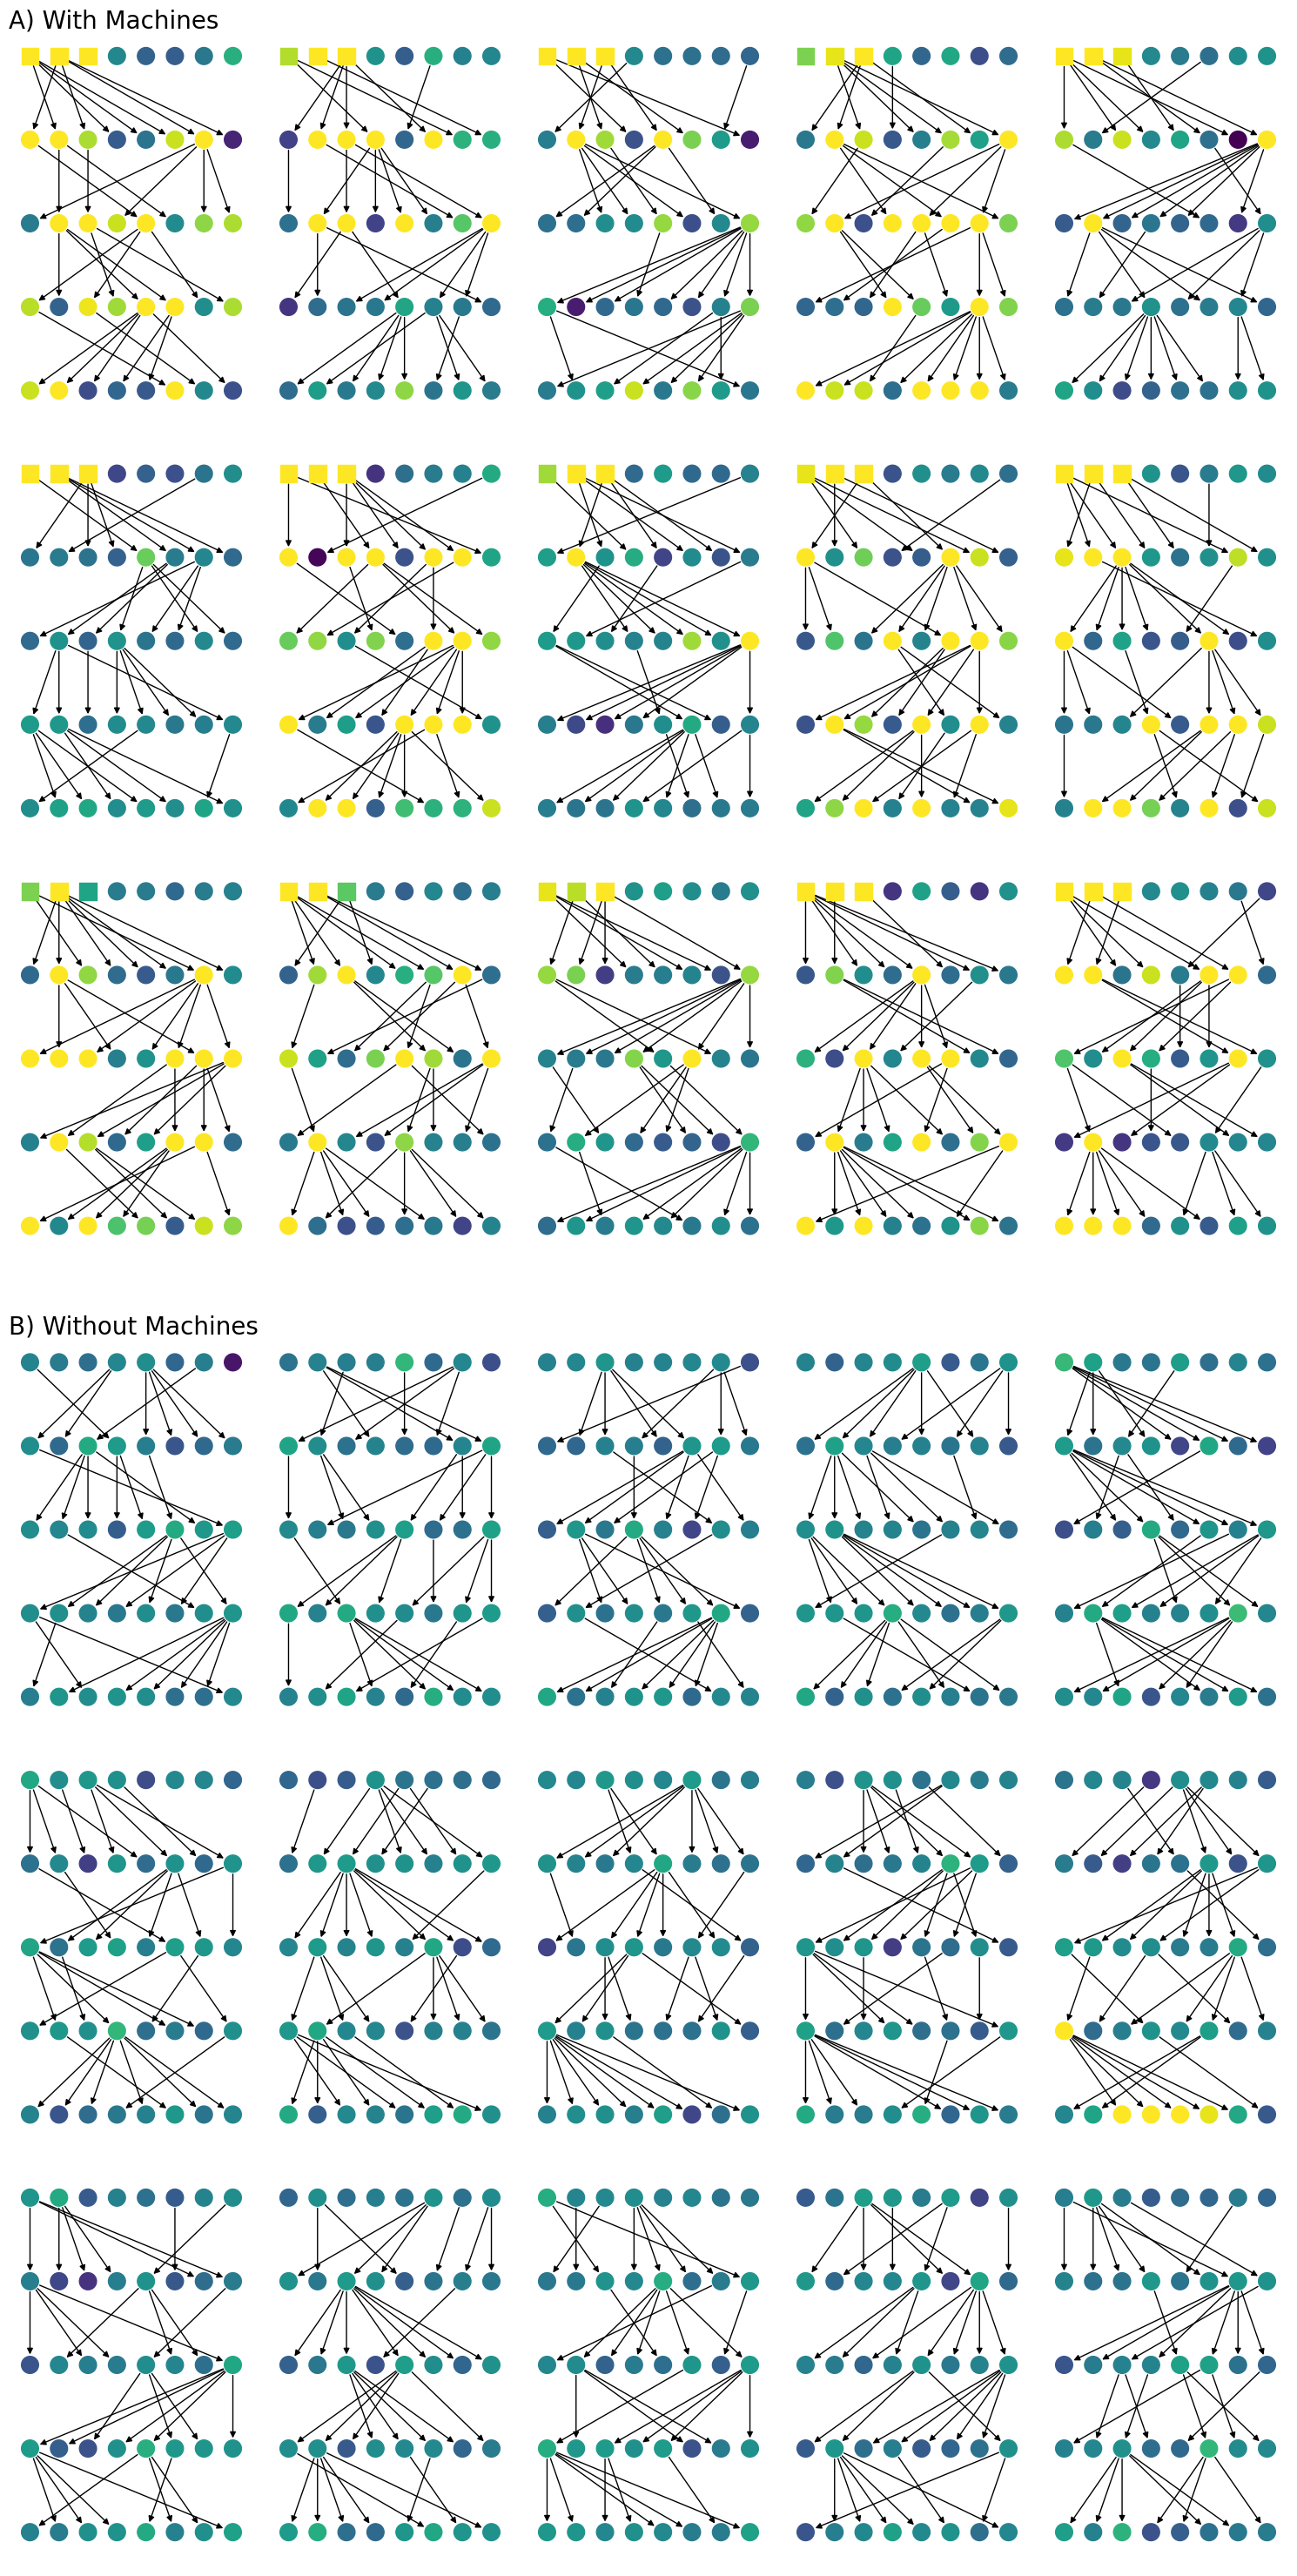

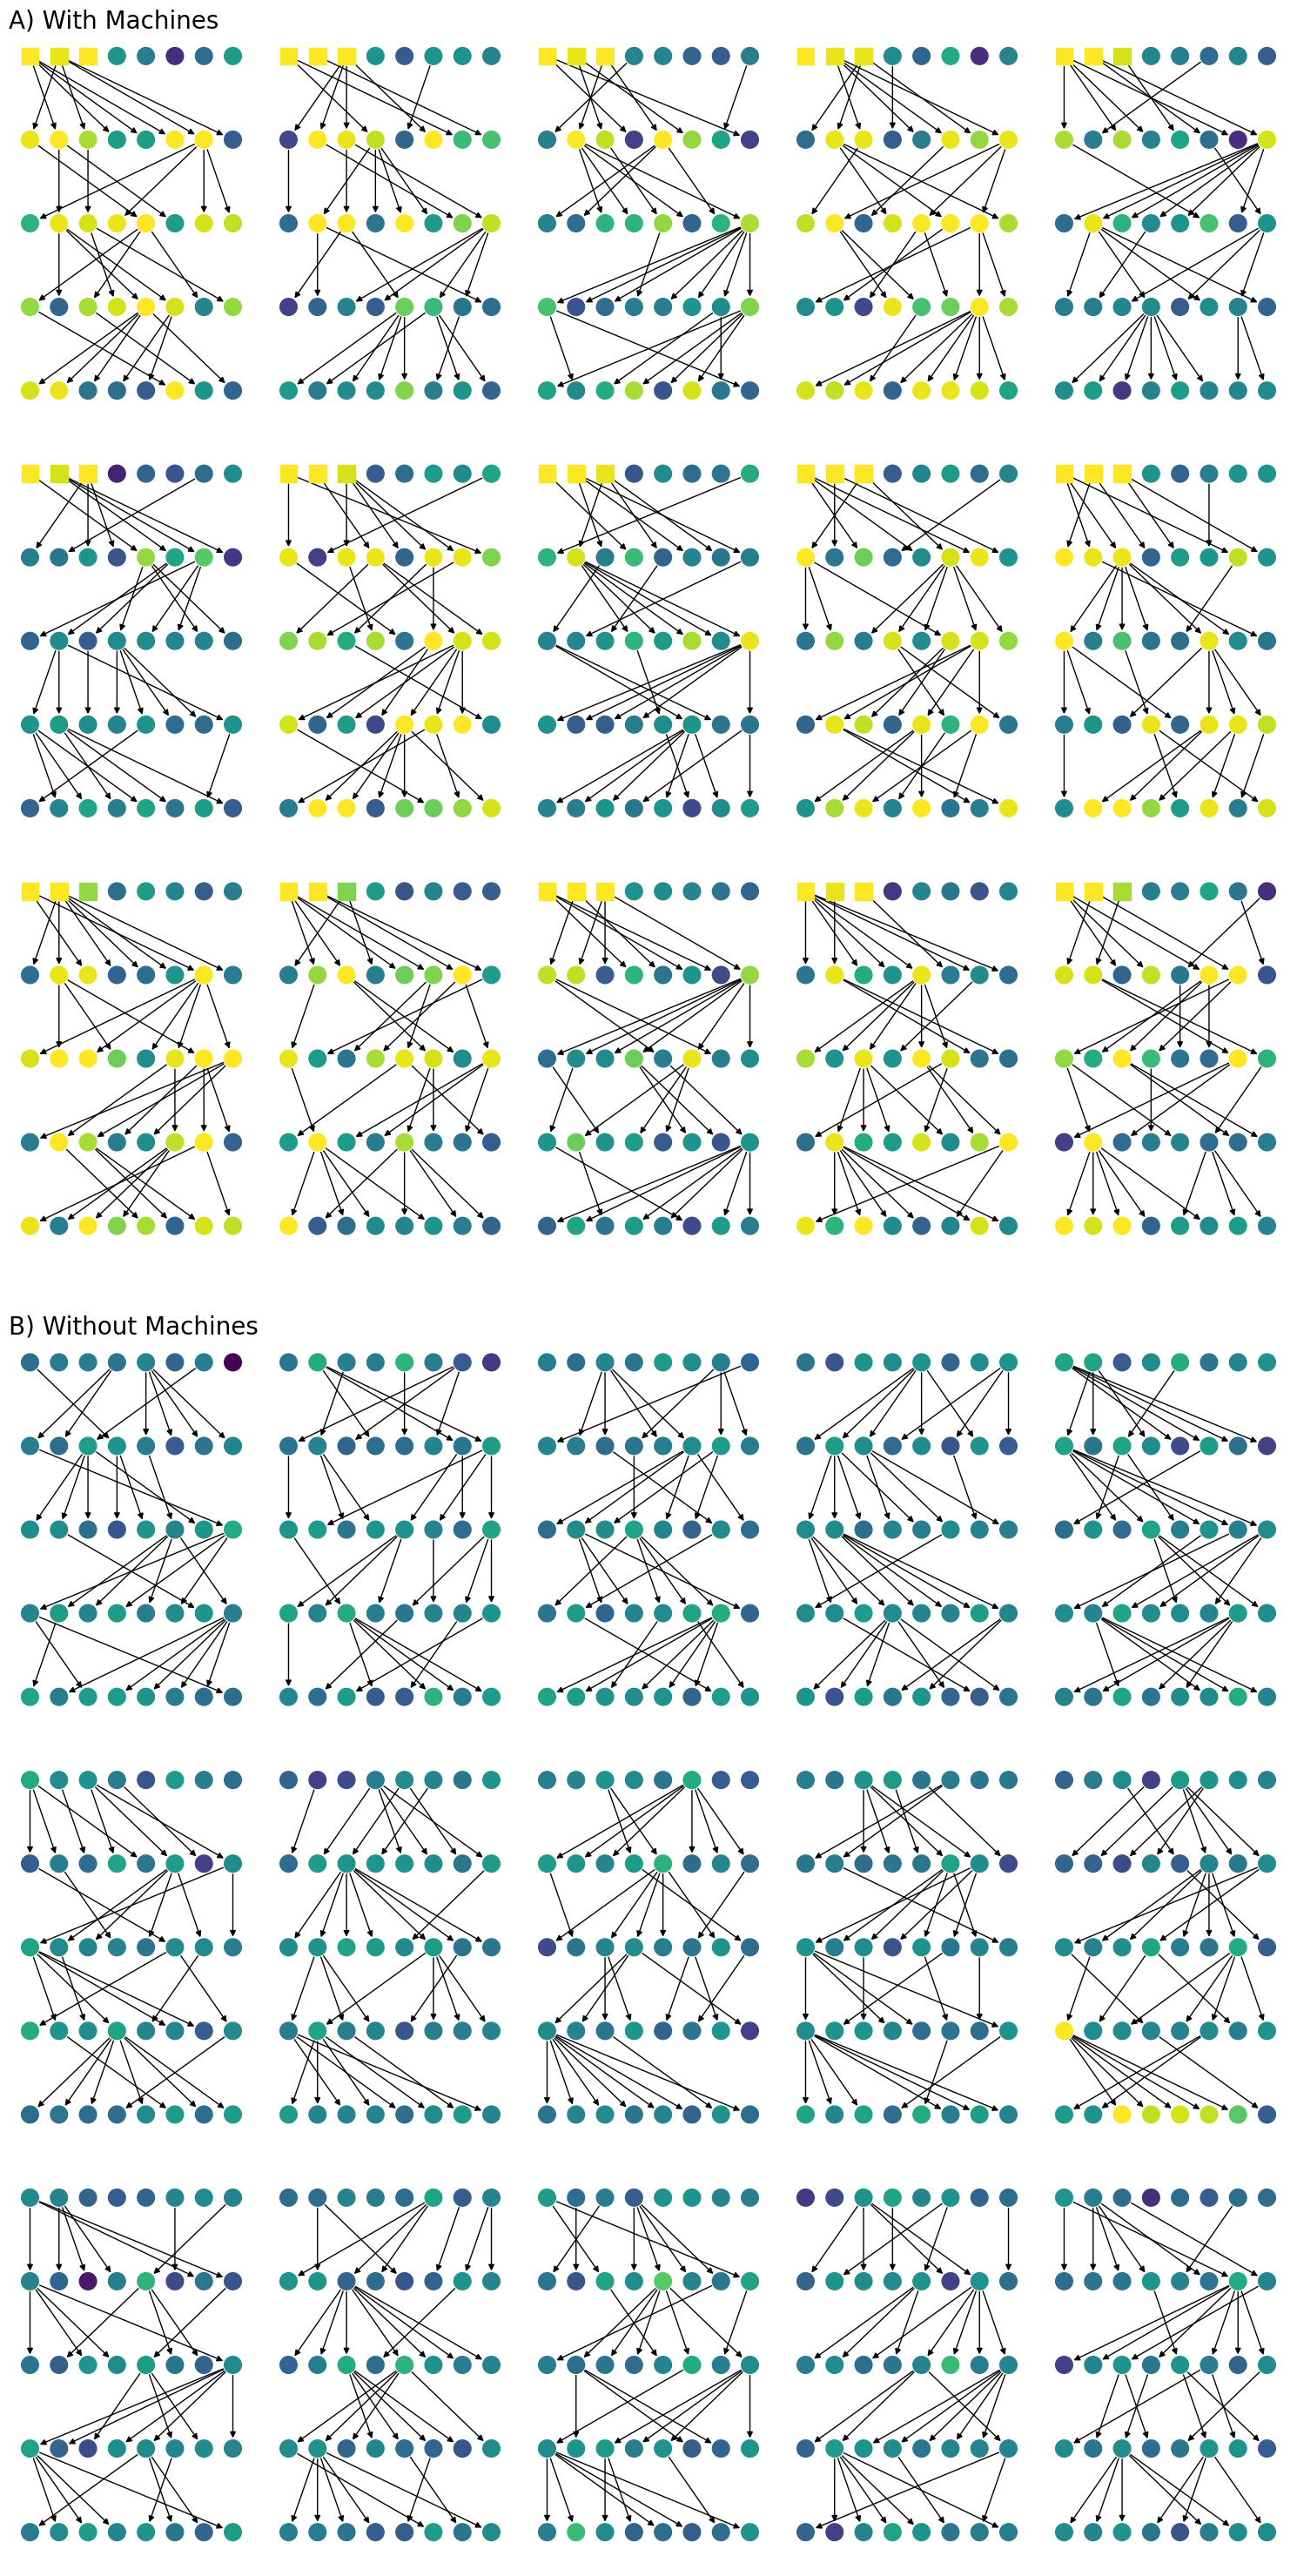

In [9]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec




for metric in metric_name.keys():

    cpick = color_map[metric]

    # Create a dictionary to store node colors, positions, and labels
    node_colors = {}
    node_positions = {}
    node_labels = {}
    node_shapes = {}
    node_size = 200

    df = player_df[player_df['replication_idx'] < 15]

    n_gen = df['generation'].max() + 1
    max_per_gen = df['within_generation_idx'].max() + 1
    n_ai = df.groupby(['replication_idx'])['ai_player'].sum().max()

    n_reps = df['replication_idx'].max() + 1

    rows = 6
    cols = n_reps // (rows // 2)

    # Create figure and define GridSpec
    fig = plt.figure(figsize=(cols*3, rows*5))
    gs = gridspec.GridSpec(rows + 1, cols, height_ratios=[1, 1, 1, 0.1, 1, 1, 1])  # Adjust the grid layout


    # Iterate through the DataFrame
    for (rep_idx, con), rep_df in df.groupby(['replication_idx', 'condition']):
        # Create a directed graph
        G = nx.DiGraph()
        row = rep_idx // cols + 4 if con == 'wo_ai' else rep_idx // cols
        col = rep_idx % cols
        ax = plt.subplot(gs[row, col])
        ax.axis('off')

        for idx, player in rep_df.iterrows():
            session_id = str(player['session_id'])
            # Add nodes
            G.add_node(session_id, label=player['session_name'])
            # Assign color
            node_colors[session_id] = mcolors.to_hex(cpick.to_rgba(player[metric]))
            x_shift = 0
            y_shift = n_gen
            node_positions[session_id] = ((player['within_generation_idx'] + x_shift), (y_shift - player['generation']))
            # Add labels
            node_labels[session_id] = player['session_name']
            # Assign shapes
            node_shapes[session_id] = 's' if player['ai_player'] else 'o'

            # Add edges
            if not pd.isna(player['advisor']):
                advisor_id = str(player['advisor'])
                G.add_edge(advisor_id, str(player['session_id']))
                if advisor_id not in node_colors:
                    # Assign a default color if advisor_id is not in player_df
                    node_colors[advisor_id] = 'gray'

        # Generate a list of colors for each node in the graph
        final_node_colors = [node_colors[node] for node in G.nodes()]

        # Draw the network
        for shape in set(node_shapes.values()):
            # Filter nodes by shape
            filtered_nodes = [node for node in G.nodes() if node_shapes[node] == shape]
            nx.draw_networkx_nodes(G, node_positions, nodelist=filtered_nodes,
                                node_color=[node_colors[node] for node in filtered_nodes],
                                node_shape=shape, node_size=node_size, ax=ax)
        nx.draw_networkx_edges(G, node_positions, edge_color='black', ax=ax)
        # nx.draw_networkx_labels(G, node_positions, labels=node_labels)

    fig.text(0.01, 0.98, 'A) With Machines', ha='left', va='center', fontsize=20)
    fig.text(0.01, 0.48, 'B) Without Machines', ha='left', va='center', fontsize=20)

    file_name = os.path.join('plots',experiment_type,f'network_{metric}.png')
    os.makedirs(os.path.dirname(file_name), exist_ok=True)
    plt.tight_layout()
    fig.subplots_adjust(top=0.98, right=0.99)
    plt.savefig(file_name, dpi=300, bbox_inches='tight', pad_inches=0.1)
    # plt.show()

In [10]:
plots = [
    {
        'replication_idx': 0,
        'condition': 'w_ai',
        'title': 'A) Human-Machine Populations',
        'secondary_title': '9x',
        'row': 0,
        'col': 0
    },
    {
        'replication_idx': 1,
        'condition': 'w_ai',
        # 'title': 'B) AI Trees - Lost',
        'title': '',
        'secondary_title': '6x',
        'row': 0,
        'col': 1
    },
    {
        'replication_idx': 0,
        'condition': 'wo_ai',
        'title': 'B) Human Populations',
        'secondary_title': '14x',
        'row': 0,
        'col': 3
    },
    {
        'replication_idx': 9,
        'condition': 'wo_ai',
        # 'title': 'D) AI Trees - Discovered',
        'title': '',
        'secondary_title': '1x',
        'row': 0,
        'col': 4
    }
]

/var/folders/nv/p5tx0nn545v9h6_w1wtm8cg00000gn/T/ipykernel_96533/2897489539.py:160: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/nv/p5tx0nn545v9h6_w1wtm8cg00000gn/T/ipykernel_96533/2897489539.py:160: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


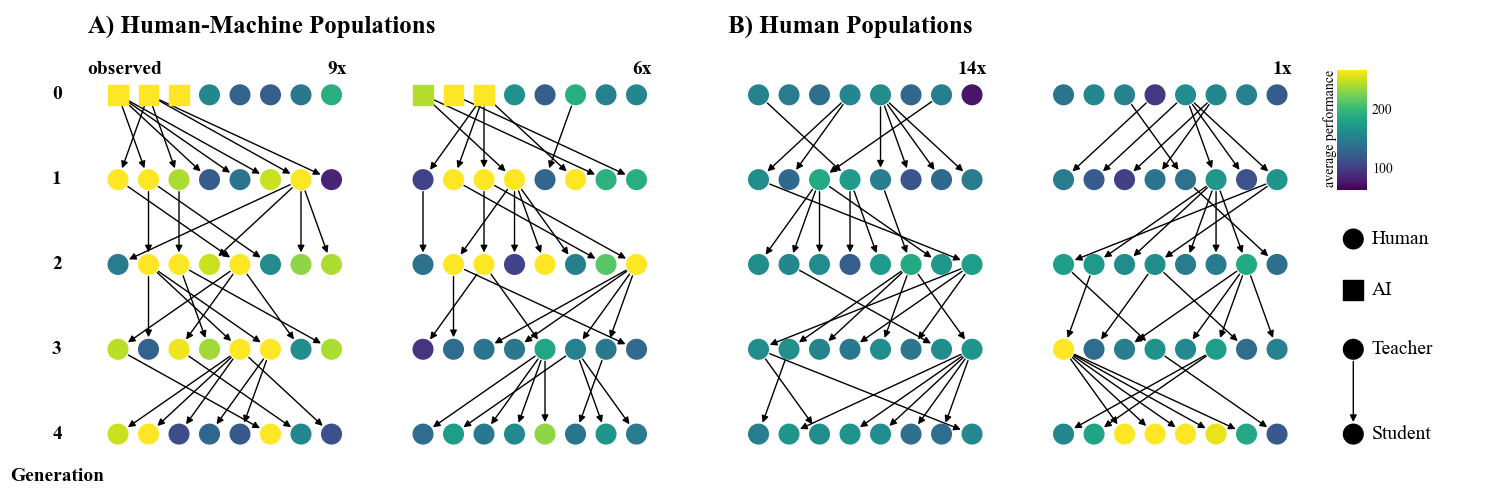

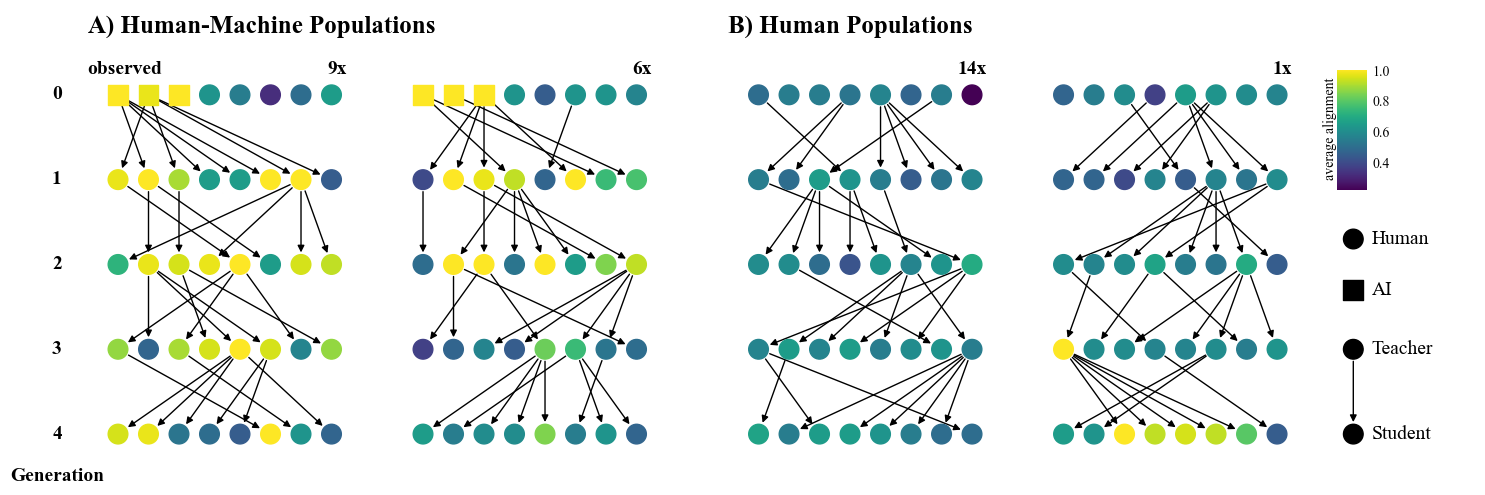

In [11]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec

mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = ['Times New Roman', 'FreeSans']

for metric, m_name in metric_name.items():

    cpick = color_map[metric]
    # Create a dictionary to store node colors, positions, and labels
    node_colors = {}
    node_positions = {}
    node_labels = {}
    node_shapes = {}
    node_size = 200

    n_gen = player_df['generation'].max() + 1

    player_df['within_generation_idx_per_tree'] = player_df.groupby(['replication_idx', 'condition', 'generation'])['within_generation_idx'].rank(method='first', ascending=True) - 1

    cols = 4
    rows = 1

    # Create figure and define GridSpec
    fig = plt.figure(figsize=((cols+1)*3, rows*5))
    gs = gridspec.GridSpec(1, 7, width_ratios=[0.1, 1, 1, 0.1, 1, 1, 0.5])  # Adjust the grid layout


    def plot_tree(df, n_gen, node_size, ax):
        G = nx.DiGraph()
        for idx, player in df.iterrows():
            session_id = str(player['session_id'])
            # Add nodes
            G.add_node(session_id, label=player['session_name'])
            # Assign color
            node_colors[session_id] = mcolors.to_hex(cpick.to_rgba(player[metric]))
            y_shift = n_gen
            node_positions[session_id] = ((player['within_generation_idx_per_tree']), (y_shift - player['generation']))
            # Add labels
            node_labels[session_id] = player['session_name']
            # Assign shapes
            node_shapes[session_id] = 's' if player['ai_player'] else 'o'

            # Add edges
            if not pd.isna(player['advisor']):
                advisor_id = str(player['advisor'])
                G.add_edge(advisor_id, str(player['session_id']))
                if advisor_id not in node_colors:
                    # Assign a default color if advisor_id is not in player_df
                    node_colors[advisor_id] = 'gray'

        # Draw the network
        for shape in set(node_shapes.values()):
            # Filter nodes by shape
            filtered_nodes = [node for node in G.nodes() if node_shapes[node] == shape]
            nx.draw_networkx_nodes(G, node_positions, nodelist=filtered_nodes,
                                node_color=[node_colors[node] for node in filtered_nodes],
                                node_shape=shape, node_size=node_size, ax=ax)
        nx.draw_networkx_edges(G, node_positions, edge_color='black', ax=ax)
        # nx.draw_networkx_labels(G, node_positions, labels=node_labels)



    def draw_network_legend(ax):
        G = nx.DiGraph()
        for i in range(4):
            G.add_node(i, label=i)
        G.add_edge(2, 3)
        node_positions = {
            0: (0, 3.3),
            1: (0, 2.7),
            2: (0, 2.0),
            3: (0, 1.0)
        }
        node_shapes = {
            0: 'o',
            1: 's',
            2: 'o',
            3: 'o'
        }
        node_colors = {
            0: 'black',
            1: 'black',
            2: 'black',
            3: 'black'
        }
        node_labels = {
            0: 'Human',
            1: 'AI',
            2: 'Teacher',
            3: 'Student'
        }


        # Draw the network
        for shape in set(node_shapes.values()):
            # Filter nodes by shape
            filtered_nodes = [node for node in G.nodes() if node_shapes[node] == shape]
            nx.draw_networkx_nodes(G, node_positions, nodelist=filtered_nodes,
                                node_color=[node_colors[node] for node in filtered_nodes],
                                node_shape=shape, node_size=node_size, ax=ax)
        nx.draw_networkx_edges(G, node_positions, edge_color='black', ax=ax)


        for pos in node_positions:
            ax.text(node_positions[pos][0] + 0.3, node_positions[pos][1], node_labels[pos], ha='left', va='center', fontsize=14)
        ax.axis('off')


    for i, plot in enumerate(plots):


        df = player_df[(player_df['replication_idx'] == plot['replication_idx']) & (player_df['condition'] == plot['condition'])]

        row = plot['row']
        col = plot['col']

        ax = plt.subplot(gs[row, col + 1])
        ax.axis('off')

        plot_tree(df, ax=ax, n_gen=n_gen, node_size=node_size)

        ax.text(-1, 5.8, plot['title'], ha='left', va='center', fontsize=18, fontweight='bold')
        ax.text(7.5, 5.3, plot['secondary_title'], ha='right', va='center', fontsize=14, fontweight='bold')
        if i == 0:
            ax.text(-1, 5.3, 'observed', ha='left', va='center', fontsize=14, fontweight='bold')
        ax.set_ylim(0.5, 6)
        ax.set_xlim(-1.5, 8.5)

    # Draw right legend
    ax = plt.subplot(gs[0, 6])

    draw_network_legend(ax)
    ax.text(-0.50, 4.6, f'average {m_name}', ha='left', va='center', fontsize=10, rotation=90)
    cbar_ax = fig.add_axes([0.898, 0.62, 0.02, 0.24])
    cb = plt.colorbar(cpick, cax=cbar_ax)
    cb.outline.set_edgecolor('none')
    cb.ax.tick_params(length=0)
    ax.set_xlim(-0.5, 2)
    ax.set_ylim(0.5, 6)

    # Add left legend
    ax = plt.subplot(gs[0, 0])
    ax.set_xlim(-1, 1)
    ax.set_ylim(0.5, 6)
    ax.axis('off')
    for i in range(5):
        ax.text(0, 5-i, f"{i}", ha='center', va='center', fontsize=14, fontweight='bold')
    ax.text(0, 0.5, 'Generation', ha='center', va='center', fontsize=14, fontweight='bold')


        # plt.colorbar(cax)

    png_filename = os.path.join('plots',experiment_type,f'network_compressed_{metric}.png')
    pdf_filename = os.path.join('plots',experiment_type,f'network_compressed_{metric}.pdf')
    os.makedirs(os.path.dirname(file_name), exist_ok=True)
    plt.tight_layout()
    fig.subplots_adjust(top=0.98, right=0.99, wspace=0.0, hspace=0.0)
    plt.savefig(png_filename, dpi=300, bbox_inches='tight', pad_inches=0.1)
    plt.savefig(pdf_filename, bbox_inches='tight', pad_inches=0.1)

    # plt.show()

In [27]:
plots = [
    {
        'replication_idx': 0,
        'condition': 'w_ai',
        'title': 'A) Human-Machine Populations',
        'secondary_title': '9x',
        'row': 0,
        'col': 0
    },
    {
        'replication_idx': 0,
        'condition': 'wo_ai',
        'title': 'B) Human Populations',
        'secondary_title': '14x',
        'row': 0,
        'col': 1
    }
]

/var/folders/nv/p5tx0nn545v9h6_w1wtm8cg00000gn/T/ipykernel_96533/500089835.py:102: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which has known issues and is not actively maintained. Consider using nx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  pos = graphviz_layout(G, prog="dot")


{'65d32e25dd6859254f5c592a': (1259.9, 306.0), '65d32e25dd6859254f5c592b': (2986.9, 306.0), '65d32e25dd6859254f5c592c': (3233.9, 306.0), '65d32e25dd6859254f5c592e': (3497.9, 306.0), '65d32e25dd6859254f5c5930': (3779.9, 306.0), '65d32e25dd6859254f5c5931': (4061.9, 306.0), '65d32e25dd6859254f5c593a': (2211.9, 234.0), '65d32e25dd6859254f5c593b': (836.94, 234.0), '65d32e25dd6859254f5c593c': (2775.9, 234.0), '65d32e25dd6859254f5c593d': (1118.9, 234.0), '65d32e26dd6859254f5c593e': (1400.9, 234.0), '65d32e26dd6859254f5c593f': (1682.9, 234.0), '65d32e26dd6859254f5c5940': (3198.9, 234.0), '65d32e2add6859254f5c594a': (2951.9, 162.0), '65d32e2add6859254f5c594b': (695.94, 162.0), '65d32e2add6859254f5c594c': (2669.9, 162.0), '65d32e2add6859254f5c594d': (3233.9, 162.0), '65d32e2bdd6859254f5c594e': (2175.9, 162.0), '65d32e2bdd6859254f5c594f': (977.94, 162.0), '65d32e2bdd6859254f5c5950': (3515.9, 162.0), '65d32e2bdd6859254f5c5951': (3797.9, 162.0), '65d32e2edd6859254f5c595a': (1823.9, 90.0), '65d32e2ed

/var/folders/nv/p5tx0nn545v9h6_w1wtm8cg00000gn/T/ipykernel_96533/500089835.py:102: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which has known issues and is not actively maintained. Consider using nx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  pos = graphviz_layout(G, prog="dot")


{'65d32e25dd6859254f5c5933': (436.49, 306.0), '65d32e25dd6859254f5c5934': (732.49, 306.0), '65d32e25dd6859254f5c5936': (1032.5, 306.0), '65d32e25dd6859254f5c5937': (1407.5, 306.0), '65d32e25dd6859254f5c5938': (1782.5, 306.0), '65d32e25dd6859254f5c5939': (2303.5, 306.0), '65d32e26dd6859254f5c5942': (2530.5, 234.0), '65d3382cdd6859254f5c5de5': (2675.5, 306.0), '65d32e26dd6859254f5c5943': (2821.5, 234.0), '65d32e26dd6859254f5c5944': (1782.5, 234.0), '65d32e26dd6859254f5c5945': (3124.5, 234.0), '65d342d44e88d3e00bab0cb4': (3124.5, 306.0), '65d32e26dd6859254f5c5946': (582.49, 234.0), '65d32e26dd6859254f5c5947': (882.49, 234.0), '65d32e26dd6859254f5c5948': (1182.5, 234.0), '65d32e26dd6859254f5c5949': (1482.5, 234.0), '65d32e2bdd6859254f5c5952': (1343.5, 162.0), '65d32e2bdd6859254f5c5953': (1634.5, 162.0), '65d32e2bdd6859254f5c5954': (1930.5, 162.0), '65d32e2bdd6859254f5c5956': (2830.5, 162.0), '65d32e2bdd6859254f5c5957': (582.49, 162.0), '65d32e2bdd6859254f5c5958': (2230.5, 162.0), '65d32e2b

/var/folders/nv/p5tx0nn545v9h6_w1wtm8cg00000gn/T/ipykernel_96533/500089835.py:102: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which has known issues and is not actively maintained. Consider using nx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  pos = graphviz_layout(G, prog="dot")


{'65d32e25dd6859254f5c592a': (1259.9, 306.0), '65d32e25dd6859254f5c592b': (2986.9, 306.0), '65d32e25dd6859254f5c592c': (3233.9, 306.0), '65d32e25dd6859254f5c592e': (3497.9, 306.0), '65d32e25dd6859254f5c5930': (3779.9, 306.0), '65d32e25dd6859254f5c5931': (4061.9, 306.0), '65d32e25dd6859254f5c593a': (2211.9, 234.0), '65d32e25dd6859254f5c593b': (836.94, 234.0), '65d32e25dd6859254f5c593c': (2775.9, 234.0), '65d32e25dd6859254f5c593d': (1118.9, 234.0), '65d32e26dd6859254f5c593e': (1400.9, 234.0), '65d32e26dd6859254f5c593f': (1682.9, 234.0), '65d32e26dd6859254f5c5940': (3198.9, 234.0), '65d32e2add6859254f5c594a': (2951.9, 162.0), '65d32e2add6859254f5c594b': (695.94, 162.0), '65d32e2add6859254f5c594c': (2669.9, 162.0), '65d32e2add6859254f5c594d': (3233.9, 162.0), '65d32e2bdd6859254f5c594e': (2175.9, 162.0), '65d32e2bdd6859254f5c594f': (977.94, 162.0), '65d32e2bdd6859254f5c5950': (3515.9, 162.0), '65d32e2bdd6859254f5c5951': (3797.9, 162.0), '65d32e2edd6859254f5c595a': (1823.9, 90.0), '65d32e2ed

/var/folders/nv/p5tx0nn545v9h6_w1wtm8cg00000gn/T/ipykernel_96533/500089835.py:102: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which has known issues and is not actively maintained. Consider using nx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  pos = graphviz_layout(G, prog="dot")


{'65d32e25dd6859254f5c5933': (436.49, 306.0), '65d32e25dd6859254f5c5934': (732.49, 306.0), '65d32e25dd6859254f5c5936': (1032.5, 306.0), '65d32e25dd6859254f5c5937': (1407.5, 306.0), '65d32e25dd6859254f5c5938': (1782.5, 306.0), '65d32e25dd6859254f5c5939': (2303.5, 306.0), '65d32e26dd6859254f5c5942': (2530.5, 234.0), '65d3382cdd6859254f5c5de5': (2675.5, 306.0), '65d32e26dd6859254f5c5943': (2821.5, 234.0), '65d32e26dd6859254f5c5944': (1782.5, 234.0), '65d32e26dd6859254f5c5945': (3124.5, 234.0), '65d342d44e88d3e00bab0cb4': (3124.5, 306.0), '65d32e26dd6859254f5c5946': (582.49, 234.0), '65d32e26dd6859254f5c5947': (882.49, 234.0), '65d32e26dd6859254f5c5948': (1182.5, 234.0), '65d32e26dd6859254f5c5949': (1482.5, 234.0), '65d32e2bdd6859254f5c5952': (1343.5, 162.0), '65d32e2bdd6859254f5c5953': (1634.5, 162.0), '65d32e2bdd6859254f5c5954': (1930.5, 162.0), '65d32e2bdd6859254f5c5956': (2830.5, 162.0), '65d32e2bdd6859254f5c5957': (582.49, 162.0), '65d32e2bdd6859254f5c5958': (2230.5, 162.0), '65d32e2b

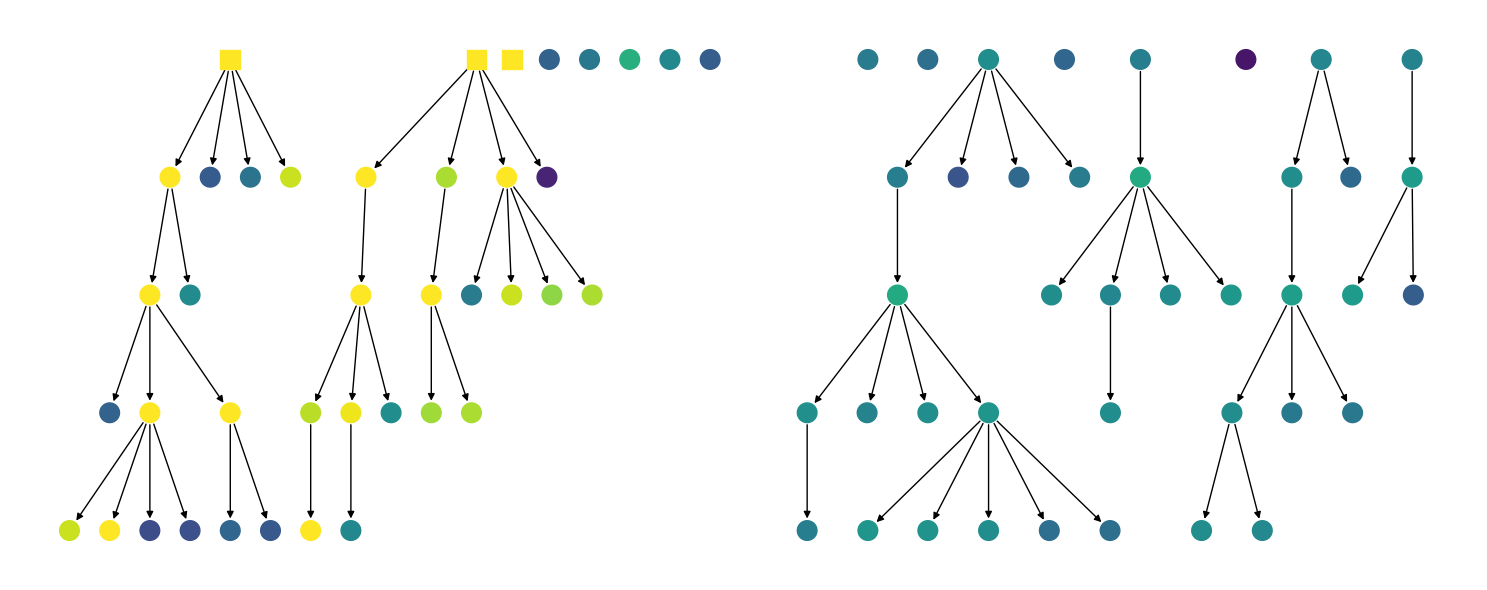

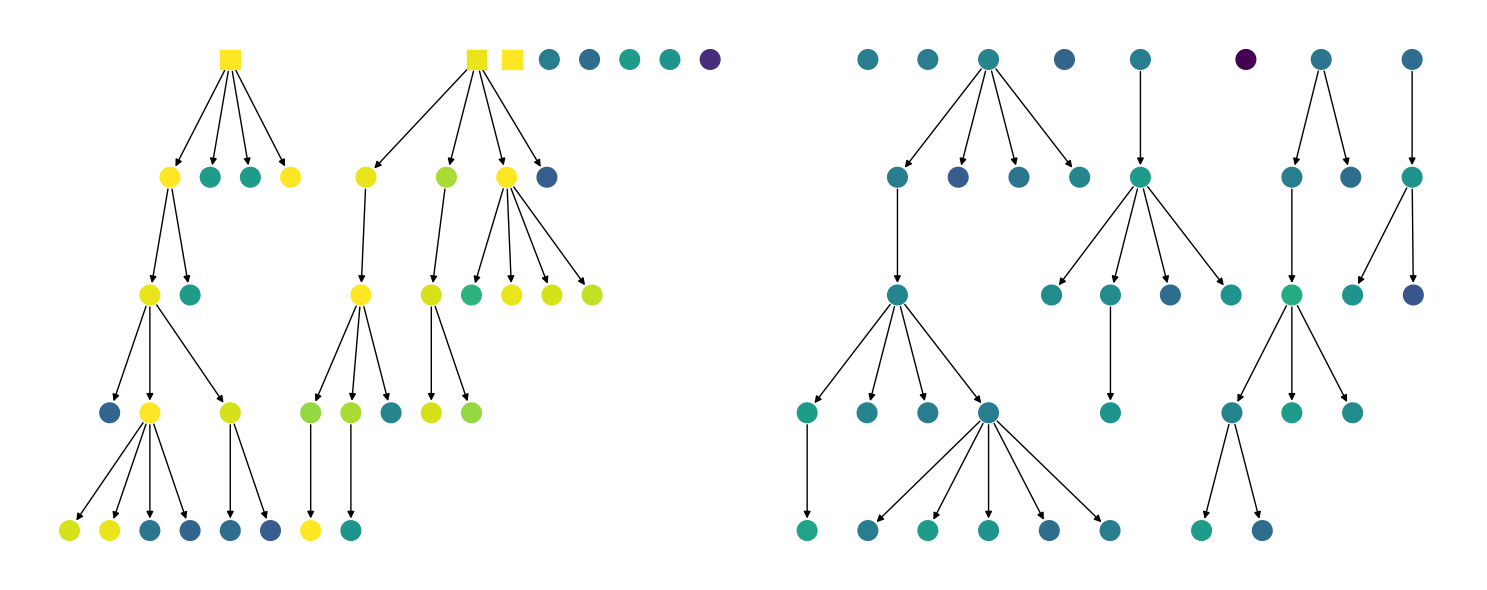

In [30]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec
from networkx.drawing.nx_pydot import graphviz_layout


mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = ['Times New Roman', 'FreeSans']

dfp = player_df.copy()

for metric, m_name in metric_name.items():

    cpick = color_map[metric]
    # Create a dictionary to store node colors, positions, and labels
    node_colors = {}
    node_positions = {}
    node_labels = {}
    node_shapes = {}
    node_size = 200

    n_gen = dfp['generation'].max() + 1


    dfp['pos_idx'] = dfp.groupby(['replication_idx', 'condition', 'generation'])['within_generation_idx'].rank(method='first', ascending=True) - 1




    # for generation in range(0, n_gen, -1):
    #     w_parent = dfp['generation'] == generation + 1
    #     w_student = dfp['generation'] == generation

    #     # advisor_map = {
    #     #     row['session_id']: row['pos_idx']
    #     #     for idx, row in dfp[w_parent].iterrows()
    #     # }

    #     dfp.loc[w_parent, 'last_gen_students'] = dfp[w_parent]['session'].map(student_count)


    #     student_count = dfp['advisor'].value_counts()


    dfp['pos_idx'] = dfp['pos_idx'] * 5

    dfp['first_gen_advisors'] = dfp['session_id']
    for generation in range(1, n_gen):
        w_parent = dfp['generation'] == generation - 1
        w_student = dfp['generation'] == generation

        advisor_map = {
            row['session_id']: row['pos_idx']
            for idx, row in dfp[w_parent].iterrows()
        }
        first_gen_advisors_map = {
            row['session_id']: row['first_gen_advisors']
            for idx, row in dfp[w_parent].iterrows()
        }
        dfp.loc[w_student, 'parent_pos_idx'] = dfp[w_student]['advisor'].map(advisor_map)
        dfp.loc[w_student, 'first_gen_advisors'] = dfp[w_student]['advisor'].map(first_gen_advisors_map)

        dfp.loc[w_student, 'parent_pos_idx'] = (dfp[w_student]['parent_pos_idx'] + np.random.random(len(dfp[w_student])) * 0.5)

        dfp.loc[w_student, 'pos_idx'] = dfp[w_student].groupby(['replication_idx', 'condition'])['parent_pos_idx'].rank(method='first', ascending=True) - 1


    cols = 4
    rows = 1

    # Create figure and define GridSpec
    fig = plt.figure(figsize=((cols+1)*3, rows*6))
    gs = gridspec.GridSpec(1, 2)  # Adjust the grid layout


    def plot_tree(df, n_gen, node_size, ax):
        G = nx.DiGraph()
        for idx, player in df.iterrows():
            session_id = str(player['session_id'])
            # Add nodes
            G.add_node(session_id, label=player['session_name'])
            # Assign color
            node_colors[session_id] = mcolors.to_hex(cpick.to_rgba(player[metric]))
            y_shift = n_gen
            node_positions[session_id] = ((player['pos_idx']), (y_shift - player['generation']))
            # Add labels
            node_labels[session_id] = player['session_name']
            # Assign shapes
            node_shapes[session_id] = 's' if player['ai_player'] else 'o'

            # Add edges
            if not pd.isna(player['advisor']):
                advisor_id = str(player['advisor'])
                G.add_edge(advisor_id, str(player['session_id']))
                if advisor_id not in node_colors:
                    # Assign a default color if advisor_id is not in player_df
                    node_colors[advisor_id] = 'gray'

        pos = graphviz_layout(G, prog="dot")

        print(pos)

        # Draw the network
        for shape in set(node_shapes.values()):
            # Filter nodes by shape
            filtered_nodes = [node for node in G.nodes() if node_shapes[node] == shape]
            nx.draw_networkx_nodes(G, pos, nodelist=filtered_nodes,
                                node_color=[node_colors[node] for node in filtered_nodes],
                                node_shape=shape, node_size=node_size, ax=ax)
        nx.draw_networkx_edges(G, pos, edge_color='black', ax=ax)
        # nx.draw_networkx_labels(G, node_positions, labels=node_labels)


    for i, plot in enumerate(plots):


        df = dfp[(dfp['replication_idx'] == plot['replication_idx']) & (dfp['condition'] == plot['condition'])]

        row = plot['row']
        col = plot['col']

        ax = plt.subplot(gs[row, col])
        ax.axis('off')

        plot_tree(df, ax=ax, n_gen=n_gen, node_size=node_size)

    png_filename = os.path.join('plots',experiment_type,f'network_exploded_{metric}.png')
    pdf_filename = os.path.join('plots',experiment_type,f'network_exploded_{metric}.pdf')
    os.makedirs(os.path.dirname(file_name), exist_ok=True)
    plt.tight_layout()
    fig.subplots_adjust(top=0.98, right=0.99, wspace=0.0, hspace=0.0)
    plt.savefig(png_filename, dpi=300, bbox_inches='tight', pad_inches=0.1)
    plt.savefig(pdf_filename, bbox_inches='tight', pad_inches=0.1)

In [23]:
pos

NameError: name 'pos' is not defined

In [14]:
dfp_fgen = dfp.copy()
session_ai_map = dfp_fgen.set_index('session_id')['ai_player'].to_dict()
dfp_fgen['ai_offspring'] = dfp_fgen['first_gen_advisors'].map(session_ai_map)

<Axes: xlabel='offspring_count', ylabel='count'>

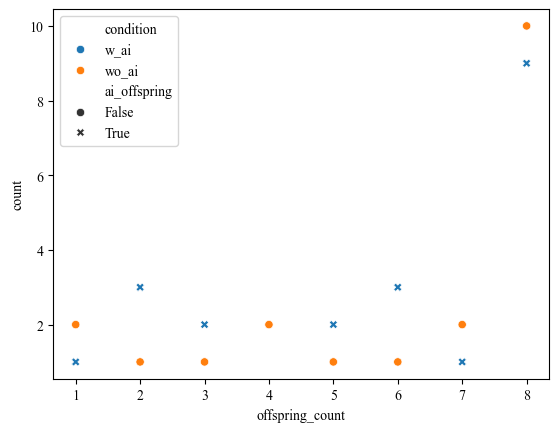

In [15]:
import seaborn as sns

adv_counts = dfp_fgen.groupby(['condition', 'generation', 'ai_offspring'])['first_gen_advisors'].value_counts().reset_index()
adv_counts = adv_counts.rename(columns={'count': 'offspring_count'})
count_dist = adv_counts.groupby(['condition', 'generation', 'ai_offspring'])['offspring_count'].value_counts().reset_index()

count_dist = count_dist[count_dist['generation'] == 4]
sns.scatterplot(data=count_dist, x='offspring_count', y='count', hue='condition', style='ai_offspring')

<Axes: xlabel='generation', ylabel='offspring_count'>

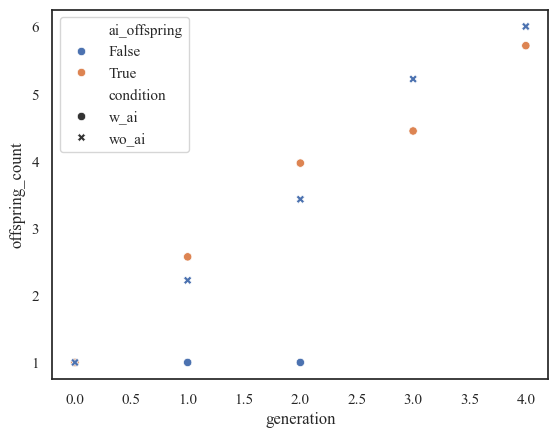

In [31]:
adv_counts_mean = adv_counts.groupby(['condition', 'generation', 'ai_offspring'])['offspring_count'].mean().reset_index()
# adv_counts_mean = adv_counts_mean[adv_counts_mean['condition'] == 'w_ai']
# sns.scatterplot(data=adv_counts, x='generation', y='offspring_count', hue='ai_offspring', style='condition')
sns.scatterplot(data=adv_counts_mean, x='generation', y='offspring_count', hue='ai_offspring', style='condition')

In [17]:
adv_counts

condition  generation  ai_offspring        first_gen_advisors  \
0        w_ai           0         False  65d32f1cdd6859254f5c5d8e   
1        w_ai           0         False  65d342d44e88d3e00bab0cb3   
2        w_ai           0         False  65d342d54e88d3e00bab0cb7   
3        w_ai           0         False  65d342d54e88d3e00bab0cb6   
4        w_ai           0         False  65d342d54e88d3e00bab0cb5   
..        ...         ...           ...                       ...   
500     wo_ai           4         False  65d32e37dd6859254f5c5988   
501     wo_ai           4         False  65d32f1ddd6859254f5c5d93   
502     wo_ai           4         False  65d3382cdd6859254f5c5de5   
503     wo_ai           4         False  65d32e48dd6859254f5c59d4   
504     wo_ai           4         False  65d32e7ddd6859254f5c5ac2   

     offspring_count  
0                  1  
1                  1  
2                  1  
3                  1  
4                  1  
..               ...  
500                4  
501                3  
502                2  
503                1  
504                1  

[505 rows x 5 columns]

In [18]:
dfp

session_id                         session_name  \
0     65d32e25dd6859254f5c592a        Rep 0 - Gen 0 - w_ai - 0 - AI   
1     65d32e25dd6859254f5c592b        Rep 0 - Gen 0 - w_ai - 1 - AI   
2     65d32e25dd6859254f5c592c        Rep 0 - Gen 0 - w_ai - 2 - AI   
3     65d32e25dd6859254f5c592e     Rep 0 - Gen 0 - w_ai - 4 - Human   
4     65d32e25dd6859254f5c5930     Rep 0 - Gen 0 - w_ai - 6 - Human   
...                        ...                                  ...   
1195  65d4bc9e5013dd177c46c9da   Rep 14 - Gen 2 - wo_ai - 8 - Human   
1196  65d4bf005013dd177c46c9de  Rep 13 - Gen 4 - wo_ai - 12 - Human   
1197  65d4c0e15013dd177c46c9e8    Rep 14 - Gen 3 - w_ai - 6 - Human   
1198  65d4cbf95013dd177c46ca01    Rep 14 - Gen 4 - w_ai - 7 - Human   
1199  65d4cc405013dd177c46ca02   Rep 14 - Gen 4 - wo_ai - 9 - Human   

      replication_idx  within_generation_idx  ai_player  generation condition  \
0                   0                      0       True           0      w_ai   
1                   0                      1       True           0      w_ai   
2                   0                      2       True           0      w_ai   
3                   0                      4      False           0      w_ai   
4                   0                      6      False           0      w_ai   
...               ...                    ...        ...         ...       ...   
1195               14                      8      False           2     wo_ai   
1196               13                     12      False           4     wo_ai   
1197               14                      6      False           3      w_ai   
1198               14                      7      False           4      w_ai   
1199               14                      9      False           4     wo_ai   

      player_score  machine_alignment                   advisor  \
0            265.0              1.000                      None   
1            265.0              0.975                      None   
2            265.0              1.000                      None   
3            125.0              0.550                      None   
4            142.5              0.500                      None   
...            ...                ...                       ...   
1195         115.0              0.375  65d32f1edd6859254f5c5da8   
1196         157.5              0.625  65d32f15dd6859254f5c5d73   
1197         155.0              0.500  65d32f22dd6859254f5c5dac   
1198         165.0              0.575  65d32f26dd6859254f5c5dbf   
1199         150.0              0.575  65d32f26dd6859254f5c5dc4   

      within_generation_idx_per_tree    pos_idx        first_gen_advisors  \
0                                0.0   0.000000  65d32e25dd6859254f5c592a   
1                                1.0   5.000000  65d32e25dd6859254f5c592b   
2                                2.0  10.000000  65d32e25dd6859254f5c592c   
3                                4.0  20.000000  65d32e25dd6859254f5c592e   
4                                6.0  30.000000  65d32e25dd6859254f5c5930   
...                              ...        ...                       ...   
1195                             0.0   0.549060  65d32f1ddd6859254f5c5d92   
1196                             4.0  10.971021  65d32f0bdd6859254f5c5d44   
1197                             6.0   1.035441  65d32f1cdd6859254f5c5d8a   
1198                             7.0  11.319654  65d32f1cdd6859254f5c5d8c   
1199                             1.0   0.488242  65d32f1ddd6859254f5c5d92   

      parent_pos_idx  
0                NaN  
1                NaN  
2                NaN  
3                NaN  
4                NaN  
...              ...  
1195        0.549060  
1196       10.971021  
1197        1.035441  
1198       11.319654  
1199        0.488242  

[1200 rows x 14 columns]

/var/folders/nv/p5tx0nn545v9h6_w1wtm8cg00000gn/T/ipykernel_96533/4151220632.py:23: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.1 -0.1  0.9  1.9  2.9  3.9 -0.1 -0.1  0.9  1.9  2.9  3.9 -0.1 -0.1
  0.9  1.9  2.9  3.9 -0.1 -0.1  0.9  1.9  2.9  3.9 -0.1 -0.1  0.9  1.9
  2.9  3.9 -0.1 -0.1  0.9  1.9  2.9  3.9 -0.1 -0.1  0.9  1.9  2.9  3.9
 -0.1 -0.1  0.9  1.9  2.9  3.9 -0.1 -0.1  0.9  1.9  2.9  3.9 -0.1 -0.1
  0.9  1.9  2.9  3.9 -0.1 -0.1  0.9  1.9  2.9  3.9 -0.1 -0.1  0.9  1.9
  2.9  3.9 -0.1 -0.1  0.9  1.9  2.9  3.9 -0.1 -0.1  0.9  1.9  2.9  3.9
 -0.1 -0.1  0.9  1.9  2.9  3.9]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  generation_df.loc[generation_df['condition'] == 'w_ai', 'generation'] = generation_df.loc[generation_df['condition'] == 'w_ai', 'generation'] - 0.1
/var/folders/nv/p5tx0nn545v9h6_w1wtm8cg00000gn/T/ipykernel_96533/4151220632.py:35: UserWarning: The pal

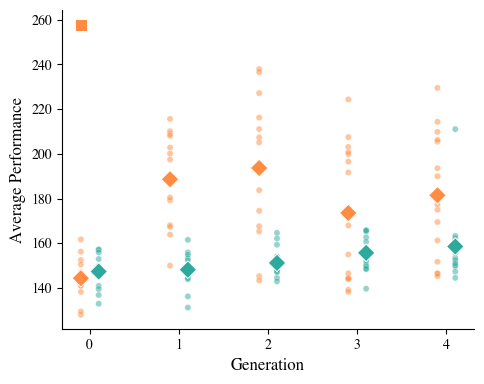

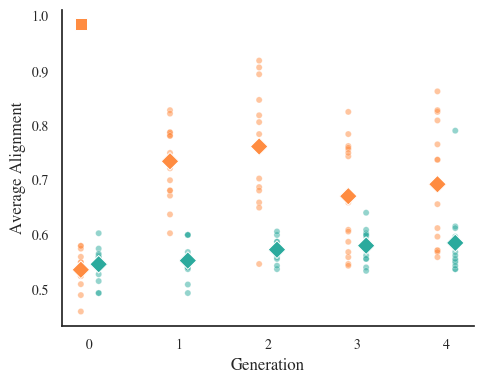

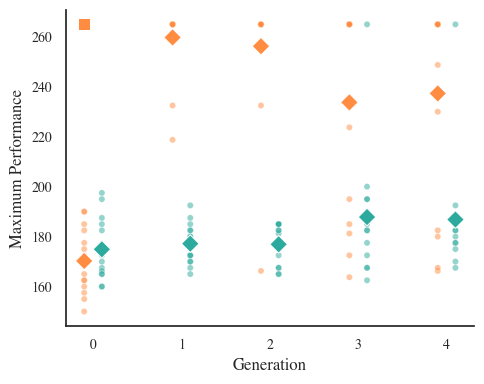

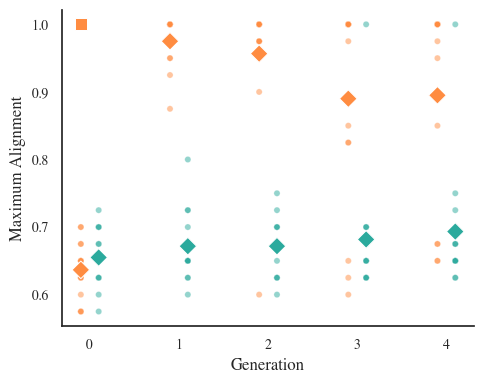

In [19]:
import seaborn as sns

legend = False
plot_machines = True

for agg in ['mean', 'max']:

    for metric, m_name in metric_name.items():

        generation_df = player_df.groupby(['replication_idx', 'generation', 'condition', 'ai_player'])[metric].apply(agg).reset_index()


        plt.figure(figsize=(5, 4))
        ax = plt.subplot()
        sns.set_theme(style='white', rc={'font.family': 'serif', 'font.serif': ['Times', 'Times New Roman', 'FreeSans']})



        generation_df['condition_str'] = generation_df['condition'].replace({'w_ai': 'Human-Machine Population', 'wo_ai': 'Human Population'})



        generation_df.loc[generation_df['condition'] == 'w_ai', 'generation'] = generation_df.loc[generation_df['condition'] == 'w_ai', 'generation'] - 0.1
        generation_df.loc[generation_df['condition'] == 'wo_ai', 'generation'] = generation_df.loc[generation_df['condition'] == 'wo_ai', 'generation'] + 0.1

        hue_order = ['Human Population', 'Human-Machine Population',]

        custom_palette = ['#379683', '#E27D60', '#8E8DAA']
        # custom_palette = ['#2C7BB6', '#FFA07A', '#97D95C']
        custom_palette = ['#2BAA9D', '#FF8C41', '#7F37B6', ]


        human_df = generation_df[generation_df['ai_player'] == False]

        sns.scatterplot(data=human_df, x='generation', y=metric, hue='condition_str', hue_order=hue_order, s=20, alpha=0.5, ax=ax, legend=False, palette=custom_palette)

        generation_mean_df = human_df.groupby(['generation', 'condition_str'])[metric].mean().reset_index()

        sns.scatterplot(data=generation_mean_df, x='generation', y=metric, hue='condition_str', hue_order=hue_order, s=80, alpha=1, ax=ax, marker='D', palette=custom_palette, legend=legend)

        if plot_machines:
            machine_df = generation_df[generation_df['ai_player'] == True]

            generation_mean_df = machine_df.groupby(['generation', 'condition_str'])[metric].mean().reset_index()

            sns.scatterplot(data=generation_mean_df, x='generation', y=metric, hue='condition_str', hue_order=hue_order, s=80, alpha=1, ax=ax, marker='s', palette=custom_palette, legend=False)


        ax.set_xlabel('Generation', fontsize=12)

        agg_label = 'Average' if agg == 'mean' else 'Maximum'
        ax.set_ylabel(f'{agg_label} {m_name.capitalize()}', fontsize=12)



        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        if legend:
            ax.legend(frameon=False, fontsize=10)

        ax.tick_params(axis='both', which='major', labelsize=10)


        png_filename = os.path.join('plots',experiment_type,f'{metric}_{agg}.png')
        pdf_filename = os.path.join('plots',experiment_type,f'{metric}_{agg}.pdf')
        os.makedirs(os.path.dirname(file_name), exist_ok=True)
        plt.tight_layout()
        fig.subplots_adjust(top=0.98, right=0.99)
        plt.savefig(png_filename, dpi=300, bbox_inches='tight', pad_inches=0.1)
        plt.savefig(pdf_filename, bbox_inches='tight', pad_inches=0.1)